In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import math
import copy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import Ridge,Lasso
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
sample = pd.read_csv('sample.csv')
X_test = pd.read_csv('X_test.csv').drop(axis=1,labels = 'id')
X_train = pd.read_csv('X_train.csv').drop(axis=1,labels = 'id')
y_train = pd.read_csv('y_train.csv').drop(axis=1,labels = 'id')
X_train


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,18707.457475,13610.725702,3785.886941,113497.632841,109.526764,97.812339,11274.011935,10803.953566,10949.811419,NaN,...,8472.132451,17727.003274,1033.057071,104.838553,102.235191,3099.069091,3.079234,1362.889974,NaN,10110.360570
1208,17108.239122,12168.536128,3442.619145,98218.773311,100.468476,109.994258,11031.326117,10231.743317,10687.321177,10.238957,...,8839.251924,14721.087037,792.061138,105.823015,109.915094,3124.059793,2.935047,1577.404870,1026.749434,10620.330033
1209,14264.707321,9273.405761,3580.894003,101668.927699,102.620705,104.470375,9159.594864,10661.827392,10623.176915,10.132906,...,10264.321725,15226.056342,831.025190,101.926717,101.669153,2252.031870,NaN,1781.799720,1066.379647,10317.757445
1210,14907.077440,10936.636575,3159.167789,100400.608972,106.622507,84.859872,10356.404262,10107.960852,10384.924460,8.239864,...,10310.165709,12976.062457,852.001070,103.098317,104.397562,2585.048660,2.731768,1300.379678,1049.370040,10876.010268


In [121]:


def select_high_correlation_features(x_train, y, x_test, threshold=0.1):
    # Combine features and labels into a DataFrame
    data = pd.DataFrame(np.column_stack((x_train, y)), columns=[f'Feature_{i}' for i in range(x_train.shape[1])] + ['Label'])
    x_test_data = pd.DataFrame(x_test, columns=[f'Feature_{i}' for i in range(x_test.shape[1])])

    # Calculate Pearson correlation coefficients
    correlations = data.corr()['Label'][:-1]

    # Select features with correlation above the threshold
    selected_features = correlations[correlations.abs() > threshold].index

    return data[selected_features].to_numpy(), x_test_data[selected_features].to_numpy()



In [122]:
def impute(X,imputer):
    X_imputed = imputer.fit_transform(X)
    return X_imputed

def remove_outliers(X_train,y_train):
    #detector=IsolationForest( n_estimators=1000,random_state=222)
    detector=LocalOutlierFactor(n_neighbors=3)
    judge= detector.fit_predict(X_train)
    n=judge != -1
    x_train_adj = X_train[n, :]
    y_train_adj = y_train[n]
    print(len(y_train)-len(y_train_adj),' outliers removed!')
    return x_train_adj, y_train_adj
      


imputer = SimpleImputer(strategy='mean')
X_train_imputed = impute(X_train,imputer)
X_test = impute(X_test,imputer)

#select high correlation features
p = 0.1
X_train_corr,X_test_corr = select_high_correlation_features(X_train_imputed,y_train,X_test,p)
print(X_test_corr.shape)
print('Kept',X_train_corr.shape[1],'features with correlation >',p)

#outlier detection
X_train_rem,y_train_rem = remove_outliers(X_train_corr,y_train)


#split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_rem, y_train_rem,test_size=0.2, random_state= 423)

(776, 186)
Kept 186 features with correlation > 0.1
126  outliers removed!


In [123]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test_corr)

corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

X_train.drop(to_drop, axis=1, inplace=True)
X_val.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)



In [124]:
X_train.columns = range(len(X_train.columns))
X_val.columns = range(len(X_train.columns))
X_test.columns = range(len(X_train.columns))

In [125]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, WhiteKernel, RationalQuadratic,Matern
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

pol_krnl = PairwiseKernel(metric='poly',pairwise_kernels_kwargs={'degree':2})
rat_krnl = RationalQuadratic()
mat_krnl = Matern(0.5)

krnl = pol_krnl + WhiteKernel(0.1)
#model = GaussianProcessRegressor(kernel=krnl, normalize_y=True, random_state=0, alpha=0.00001)

model = Ridge(alpha=1)

selection = SelectKBest(mutual_info_regression, k=15).fit(X_train,y_train)

X_train_s = selection.transform(copy.copy(X_train))
X_val_s = selection.transform(copy.copy(X_val))

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train_s)
X_val_s = scaler.transform(X_val_s)

model.fit(X_train_s,y_train)


r2_train =(model.score(X_train_s,y_train))
r2_test = (model.score(X_val_s,y_val))

r2_train,r2_test

c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.32060919033680413, 0.3525679358094944)

In [126]:
rem_X_train = copy.copy(X_train)
rem_X_val = copy.copy(X_val)
rem_X_test = copy.copy(X_test)

for col in selection.get_feature_names_out():
    col = int(col.replace('x',''))
    rem_X_train.drop(col, axis=1, inplace=True)
    rem_X_val.drop(col, axis=1, inplace=True)
    rem_X_test.drop(col, axis=1, inplace=True)




In [127]:
for feature in rem_X_train.columns:
 

    model = GaussianProcessRegressor(kernel=krnl, normalize_y=True, random_state=0, alpha=0.00001)
    scaler = StandardScaler()
  
    X_train_s = np.c_[X_train_s,scaler.fit_transform(np.expand_dims(rem_X_train[feature],1))]
    X_val_s = np.c_[X_val_s,scaler.transform(np.expand_dims(rem_X_val[feature],1))]
    

    
    model.fit(X_train_s,y_train)
    
    r2_train_new =(model.score(X_train_s,y_train))
    r2_test_new = (model.score(X_val_s,y_val))
    
    if r2_test_new > r2_test:
        r2_test = r2_test_new
        print('feature added')
    else:
        X_train_s = np.delete(X_train_s, len(X_train_s[0])-1, 1)
        X_val_s = np.delete(X_val_s, len(X_train_s[0])-1, 1)
    print('score now : ', r2_test_new)
    print('best score: ', r2_test)
    print('features in set: ', len(X_train_s[0]))
    
    
print(r2_test)

feature added
score now :  0.35586878893966245
best score:  0.35586878893966245
features in set:  16
feature added
score now :  0.38450623530698125
best score:  0.38450623530698125
features in set:  17
feature added
score now :  0.39843723746703696
best score:  0.39843723746703696
features in set:  18
feature added
score now :  0.4034400193982839
best score:  0.4034400193982839
features in set:  19
score now :  0.3953969318359739
best score:  0.4034400193982839
features in set:  19
score now :  0.39548283836815756
best score:  0.4034400193982839
features in set:  19
feature added
score now :  0.40699237463380467
best score:  0.40699237463380467
features in set:  20
score now :  0.39072635822791024
best score:  0.40699237463380467
features in set:  20
score now :  0.3969638055280206
best score:  0.40699237463380467
features in set:  20
score now :  0.1518393372545639
best score:  0.40699237463380467
features in set:  20
score now :  0.3866208999860319
best score:  0.40699237463380467
fe

In [128]:
pd.DataFrame(X_train_s).columns


RangeIndex(start=0, stop=31, step=1)

In [131]:
X_test.shape

(776, 131)

In [132]:
print(X_train.shape)

f = 0
while f < len(r):
    r = np.corrcoef(np.transpose(X_train))

    mask = []
    for i in range(len(r[f])):
        if np.abs(r[f][i]) > 0.7:
            mask.append(False)
        else:
            mask.append(True)
    X_train = np.squeeze(X_train[:,mask])
    X_val = np.squeeze(X_val[:,mask])
    X_test = np.squeeze(X_test[:,mask])
    
    f += 1


print(X_train.shape)

(868, 131)


NameError: name 'r' is not defined

In [133]:
np.corrcoef(np.transpose(X_train))

array([[ 1.        ,  0.69937074, -0.06430236, ...,  0.17107459,
         0.21530631,  0.42129432],
       [ 0.69937074,  1.        , -0.16921383, ...,  0.0600654 ,
         0.10648439,  0.47324087],
       [-0.06430236, -0.16921383,  1.        , ...,  0.35262286,
         0.22306759,  0.02497758],
       ...,
       [ 0.17107459,  0.0600654 ,  0.35262286, ...,  1.        ,
         0.4689729 ,  0.16974694],
       [ 0.21530631,  0.10648439,  0.22306759, ...,  0.4689729 ,
         1.        ,  0.21304264],
       [ 0.42129432,  0.47324087,  0.02497758, ...,  0.16974694,
         0.21304264,  1.        ]])

In [134]:
print(X_train[:,0].shape)

KeyError: (slice(None, None, None), 0)

In [135]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process.kernels import Matern, DotProduct, RationalQuadratic,WhiteKernel,RBF
for i in range(1,10,1):
    selection = SelectKBest(mutual_info_regression, k=i).fit(X_train,y_train)

    X_train_s = selection.transform(copy.copy(X_train))
    X_val_s = selection.transform(copy.copy(X_val))

    #reg = GaussianProcessRegressor(kernel = RationalQuadratic())
    reg = KernelRidge(kernel = 'poly',alpha = 1)
    reg.fit(X_train_s,y_train)
    print(reg.score(X_train_s,y_train))
    print(reg.score(X_val_s,y_val))

c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-41.20954264252603
-42.63915113035565


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-15.753347327646246
-203.61765716775687


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-6.722766010106139
-30.847516311775095


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.6870150779022948
-8.343074103800967


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.02809551905254426
-3.6317367354507235


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.15343832297493698
-14.127189039356761


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18769389498386146
-5.369077100022545


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.31918806024382107
-31.37584526439108
0.36936401797206875
-178.1148840364633


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


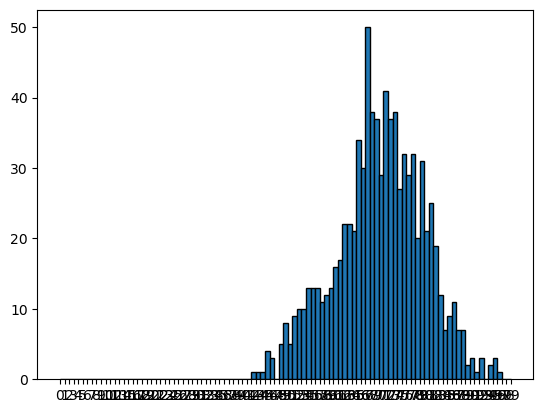

,y
3,52.0
1175,84.0
710,72.0
449,66.0
1132,60.0
576,65.0
1010,75.0
842,77.0
961,83.0
638,67.0


In [136]:



bins= range(100)


plt.hist(y_train, bins=bins, edgecolor="k")
plt.xticks(bins)

plt.show()
y_train[:20]

In [137]:
print(X_train.shape)

features_ages = copy.copy(X_train)
ages = np.array(y_train)


r = np.corrcoef(features_ages)
d =[]
for i in range(len(r[0])):
    if r[0][i] > 0.95:
        d.append(np.abs(ages[0][0]-ages[i][0]))



d

(868, 131)


[0.0,
 32.0,
 20.0,
 14.0,
 8.0,
 13.0,
 23.0,
 25.0,
 31.0,
 15.0,
 38.0,
 30.0,
 18.0,
 18.0,
 1.0,
 14.0,
 7.0,
 12.0,
 21.0,
 17.0,
 17.0,
 23.0,
 2.0,
 30.0,
 34.0,
 27.0,
 10.0,
 43.0,
 20.0,
 11.0,
 12.0,
 8.0,
 20.0,
 25.0,
 17.0,
 8.0,
 12.0,
 19.0,
 26.0,
 7.0,
 27.0,
 16.0,
 29.0,
 25.0,
 19.0,
 20.0,
 35.0,
 16.0,
 20.0,
 3.0,
 14.0,
 17.0,
 16.0,
 26.0,
 29.0,
 24.0,
 10.0,
 21.0,
 16.0,
 16.0,
 30.0,
 3.0,
 8.0,
 11.0,
 12.0,
 21.0,
 32.0,
 42.0,
 1.0,
 21.0,
 25.0,
 27.0,
 29.0,
 15.0,
 18.0,
 25.0,
 18.0,
 2.0,
 10.0,
 16.0,
 18.0,
 1.0,
 21.0,
 23.0,
 17.0,
 14.0,
 26.0,
 12.0,
 16.0,
 13.0,
 26.0,
 23.0,
 31.0,
 29.0,
 27.0,
 28.0,
 14.0,
 4.0,
 4.0,
 40.0,
 12.0,
 27.0,
 19.0,
 13.0,
 0.0,
 18.0,
 12.0,
 24.0,
 5.0,
 16.0,
 21.0,
 3.0,
 23.0,
 24.0,
 5.0,
 2.0,
 21.0,
 10.0,
 19.0,
 10.0,
 14.0,
 16.0,
 10.0,
 10.0,
 13.0,
 29.0,
 1.0,
 19.0,
 12.0,
 26.0,
 25.0,
 29.0,
 26.0,
 18.0,
 30.0,
 5.0,
 17.0,
 20.0,
 17.0,
 15.0,
 22.0,
 5.0,
 13.0,
 21.0,
 24.0,
 29.0,
 3

In [ ]:
ages

array([[62.],
       [64.],
       [79.],
       [57.],
       [54.],
       [68.],
       [70.],
       [63.],
       [57.],
       [62.],
       [58.],
       [73.],
       [67.],
       [78.],
       [71.],
       [65.],
       [85.],
       [68.],
       [79.],
       [72.],
       [58.],
       [48.],
       [54.],
       [75.],
       [73.],
       [51.],
       [50.],
       [48.],
       [54.],
       [54.],
       [70.],
       [67.],
       [76.],
       [77.],
       [65.],
       [56.],
       [68.],
       [60.],
       [78.],
       [74.],
       [42.],
       [94.],
       [64.],
       [53.],
       [72.],
       [79.],
       [75.],
       [75.],
       [86.],
       [73.],
       [54.],
       [58.],
       [53.],
       [66.],
       [69.],
       [66.],
       [50.],
       [69.],
       [85.],
       [78.],
       [48.],
       [69.],
       [77.],
       [82.],
       [58.],
       [76.],
       [77.],
       [67.],
       [66.],
       [61.],
       [63.],
      

In [138]:
def better_features(X, scaler = None):
    if scaler == None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X = pd.DataFrame(X)
    X.columns = X.columns.astype(str)
    for col in X.columns:
        X[col+'_sq'] = np.square(X[col])
        X[col+'_exp'] = np.exp(X[col])
        
    return X,scaler

X_test_o,scaler = better_features(pd.read_csv('X_test.csv').drop(axis=1,labels = 'id'))
X_train_o,_ = better_features(pd.read_csv('X_train.csv').drop(axis=1,labels = 'id'),scaler)


C:\Users\lucas\AppData\Local\Temp\ipykernel_22004\2768162889.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_exp'] = np.exp(X[col])
C:\Users\lucas\AppData\Local\Temp\ipykernel_22004\2768162889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_sq'] = np.square(X[col])
C:\Users\lucas\AppData\Local\Temp\ipykernel_22004\2768162889.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [140]:

def make_predictions(X_train,y_train,X_test,model):
    
    #imputation
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = impute(X_train,imputer)
    X_test_imputed = impute(X_test,imputer)
    
    #outlier detection
    X_train_rem,y_train_rem = remove_outliers(X_train_imputed,y_train)
    
    
    #split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_rem, y_train_rem,test_size=0.2, random_state= 423)
    
    #train model
    reg = model.fit(X_train, y_train)
    training_scores = [reg.score(X_train, y_train)]
    validation_scores = [reg.score(X_val,y_val)]
    
    predictions = reg.predict(X_test_imputed)
    best_features = []
    best_score = -100000
    for i in range(1,20,1):
        print('----',i,'----')
        print(training_scores[i-1])
        print(validation_scores[i-1])
        n = math.floor((0.8**i)*(832*1))
        feature_importance = model.feature_importances_
        print(len(feature_importance))
        important_features = feature_importance.argsort()[-n:][::-1]
        
        X_train = np.squeeze(X_train[:,important_features])
        X_val = np.squeeze(X_val[:,important_features])
        X_test_imputed = np.squeeze(X_test_imputed[:,important_features])
        #print(len(X_train[0]))
        reg = model.fit(X_train, y_train)
        training_scores.append(reg.score(X_train, y_train))
        validation_scores.append(reg.score(X_val,y_val))
        
        if best_score > validation_scores[i]:
            pass
        else:
            predictions = reg.predict(X_test_imputed)
            features = [copy.copy(X_train),copy.copy(X_val),copy.copy(X_test)]
            best_score = validation_scores[i]
    
    return predictions,training_scores,validation_scores,features
        
        

In [141]:
pred3,t_score3,val_score3,features = make_predictions(X_train_o,y_train_o,X_test_o,RandomForestRegressor(max_depth=8))

NameError: name 'y_train_o' is not defined

In [ ]:
X_train,X_val,X_test = features

In [ ]:
X_train,scaler = better_features(X_train)
X_val,_ = better_features(X_val)
X_test,_ = better_features(X_test)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_exp'] = np.exp(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_sq'] = np.square(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_sq'] = np.square(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_exp'] = np.exp(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_exp'] = np.exp(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_sq'] = np.square(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_exp'] = np.exp(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col+'_sq'] = np.square(X[col])
C:\Users\Samuel\AppData\Local\Temp\ipykernel_17272\557929511.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [ ]:
X_train.shape

(901, 540)

In [ ]:
from sklearn.gaussian_process.kernels import Matern, DotProduct, RationalQuadratic,WhiteKernel,RBF
for i in [0.01,0.1,1,10,100]:
        reg = GaussianProcessRegressor(kernel = RationalQuadratic(),alpha=i)
        reg.fit(X_train,y_train)
        print(reg.score(X_train,y_train))
        print(reg.score(X_val,y_val))

0.9998738075335324
0.28802920586167435
0.989357435714164
0.28807352903190886
0.6769401063961336
0.2885014794056511


C:\Users\Samuel\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Samuel\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


-0.006190531332133098
-0.0031984204704502694
-0.512488853915676
-0.5741367102672845


C:\Users\Samuel\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Samuel\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
features


array([ 0,  1,  2,  5,  3,  9,  4,  6,  7, 10,  8], dtype=int64)